In [99]:
import fly_analysis as fa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
import seaborn as sns

In [4]:
wtcs_files = ["20240916_115831.braidz", "20240917_163455.braidz"]
root_folder = "/home/buchsbaum/mnt/DATA/Experiments/"

In [5]:
wtcs = fa.braidz.read_multiple_braidz(wtcs_files, root_folder)

Reading /home/buchsbaum/mnt/DATA/Experiments/20240916_115831.braidz using pyarrow
Reading /home/buchsbaum/mnt/DATA/Experiments/20240917_163455.braidz using pyarrow


In [104]:
def filter_trajecs(
    df,
    min_length=300,  # 50 frames = 0.5 seconds
    max_z_speed=0.3,  # shouldn't be flying up/down a lot
    min_speed=0.05,  # should be flying (not wallking)
):
    selected_obj_ids = []

    for obj_id, gdf in df.groupby("obj_id"):
        if len(gdf) > min_length:
            speed = np.linalg.norm(np.vstack([gdf.zvel, gdf.xvel, gdf.yvel]), axis=0)

            if gdf.z.min() > 0.05:  # not on floor
                if gdf.z.max() < 0.5:  # not on ceiling
                    if np.max(np.abs(gdf.zvel)) < max_z_speed:
                        if np.min(speed[5:]) > min_speed:  # first few frames are off
                            selected_obj_ids.append(obj_id)

    return df.loc[df["obj_id"].isin(selected_obj_ids)]

def angdiff(theta1, theta2):
    return np.arctan2(np.sin(theta1 - theta2), np.cos(theta1 - theta2))

def get_saccade_amplitude(xvel, yvel, idx):
    heading_before = np.arctan2(yvel[idx - 10], xvel[idx - 10])
    heading_after = np.arctan2(yvel[idx + 10], xvel[idx + 10])
    heading_difference = angdiff(heading_before, heading_after)
    return heading_difference

def split_on_jumps(df, column='frame', k=1, n=300):
    # Calculate the differences between consecutive values
    diffs = df[column].diff()
    
    # Find where the differences are greater than k
    split_indices = np.where(diffs > k)[0]
    
    # Split the dataframe
    if len(split_indices) > 0:
        result = np.split(df, split_indices)
    
        # Remove empty dataframes (if any)
        result = [r for r in result if len(r) > n and not r.empty]
    else:
        result = [df]
    
    return result

def detect_saccades(angvel, **kwargs):
    thresh = np.deg2rad(kwargs.get("threshold", 500))
    dist = kwargs.get("distance", 10)
    positive_peaks, _ = find_peaks(angvel, height=thresh, distance=dist)
    negative_peaks, _ = find_peaks(-angvel, height=thresh, distance=dist)
    return np.sort(np.concatenate((positive_peaks, negative_peaks)))

def process_fly_trajectories(
    df,
    x_bounds=(-0.25, 0.25),
    y_bounds=(-0.25, 0.25),
    z_bounds=(0.00, 0.35),
    min_trajectory_length=300,
):
    
    angvels = []
    linvels = []
    accels = []
    amplitudes = []
    isi = []
    for obj_id, grp in df.groupby("unique_obj_id"):

        if len(grp) < min_trajectory_length:
            continue
        
        # make a clone of grp
        grp_new = grp.copy()

        # find indices in range
        x, y, z = grp.x.to_numpy(), grp.y.to_numpy(), grp.z.to_numpy()
        indices_in_range = (x >= x_bounds[0]) & (x <= x_bounds[1]) & (y >= y_bounds[0]) & (y <= y_bounds[1]) & (z >= z_bounds[0]) & (z <= z_bounds[1])
        grp_new = grp_new.iloc[indices_in_range]

        # split dataframes
        result = split_on_jumps(grp_new, column="frame", k=1)
        x = savgol_filter(result[0]["x"], 21, 3)
        y = savgol_filter(result[0]["y"], 21, 3)
        z = savgol_filter(result[0]["z"], 21, 3)
        xvel = savgol_filter(result[0]["xvel"], 21, 3)
        yvel = savgol_filter(result[0]["yvel"], 21, 3)

        # angular velocity
        theta = np.arctan2(yvel, xvel)
        theta_u = np.unwrap(theta)
        angular_velocity = np.gradient(theta_u, 0.01)

        # linear velocity
        linear_velocity = np.sqrt(xvel**2+yvel**2)

        # linear acceleration
        linear_acceleration = np.gradient(linear_velocity, 0.01)

        # saccade indices
        saccades = detect_saccades(angular_velocity, threshold=500, distance=10)
        
        # loop over saccade indices
        for sac in saccades:
            if sac-25 < 0 or sac+25 > len(angular_velocity):
                continue

            angvels.append(angular_velocity[sac-25:sac+25])
            linvels.append(linear_velocity[sac-25:sac+25])
            accels.append(linear_acceleration[sac-25:sac+25])
            amplitudes.append(get_saccade_amplitude(xvel, yvel, sac))
        isi.append(np.diff(saccades))

    return np.asarray(angvels), np.asarray(linvels), np.asarray(accels), np.asarray(amplitudes), isi

In [105]:
gdf = filter_trajecs(wtcs["df"])

In [106]:
unique_obj_id = gdf["unique_obj_id"].unique()
print(len(unique_obj_id))

32


In [108]:
angvels, linvels, accels, amplitudes, isi = process_fly_trajectories(gdf)
print(len(angvels))

195


### Distributions

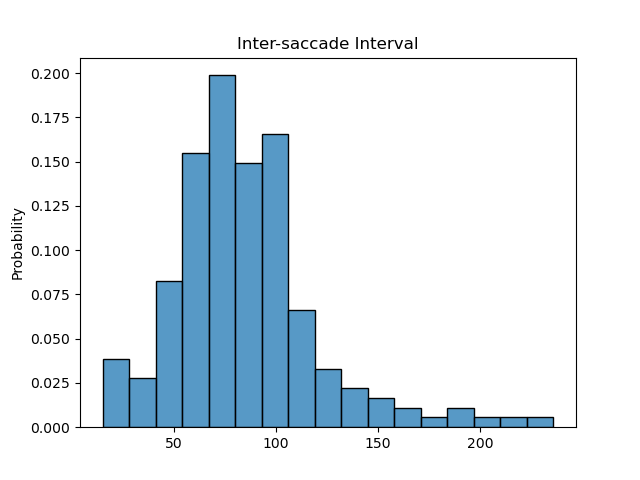

In [109]:

fig = plt.figure()
sns.histplot(np.concatenate(isi), stat="probability")
plt.title("Inter-saccade Interval")
plt.show()

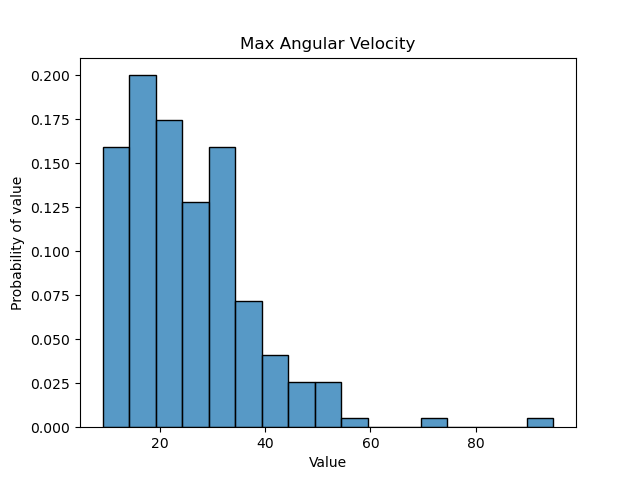

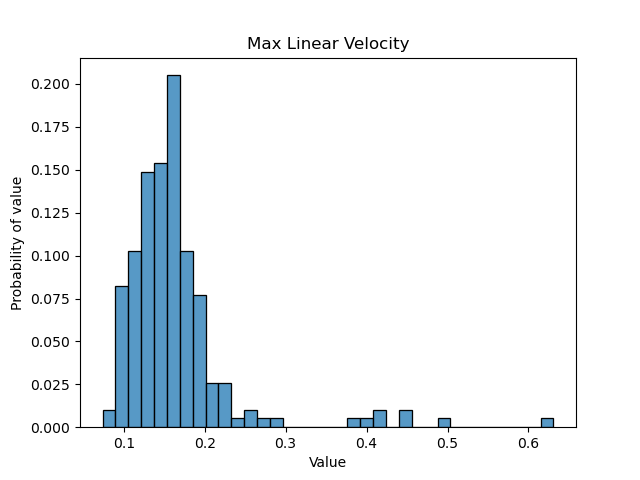

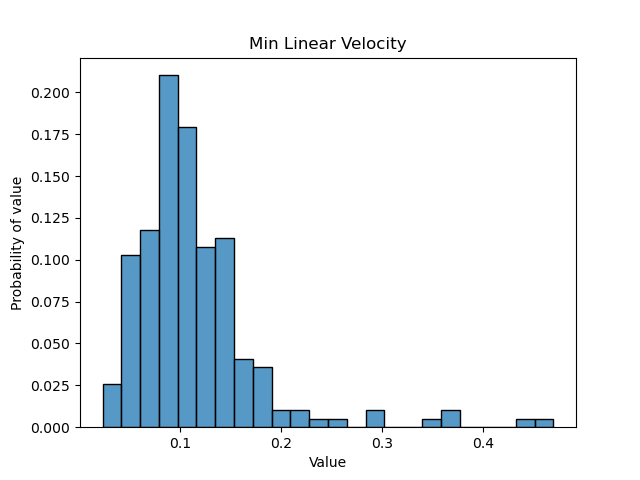

In [110]:
def plot_hist(data, bins=12, label=""):
    fig = plt.figure()
    sns.histplot(data, stat="probability")
    plt.title(label)
    plt.xlabel("Value")
    plt.ylabel("Probability of value")
    plt.show()

max_angvel_in_range = np.max(np.abs(np.asarray(angvels)[:, 20:30]), axis=1)
plot_hist(max_angvel_in_range, bins=20, label="Max Angular Velocity")

max_linvel_in_range = np.max(np.abs(np.asarray(linvels)[:, 20:30]), axis=1)
plot_hist(max_linvel_in_range, bins=20, label="Max Linear Velocity")

min_linvel_in_range = np.min(np.abs(np.asarray(linvels)[:, 20:30]), axis=1)
plot_hist(min_linvel_in_range, bins=20, label="Min Linear Velocity")



In [111]:
max_angvel = np.max(np.abs(angvels), axis=1)
min_linvel, max_linvel = np.min(linvels, axis=1), np.max(linvels, axis=1)
min_accel, max_accel = np.min(accels, axis=1), np.max(accels, axis=1)
print(np.shape(max_angvel))

(195,)


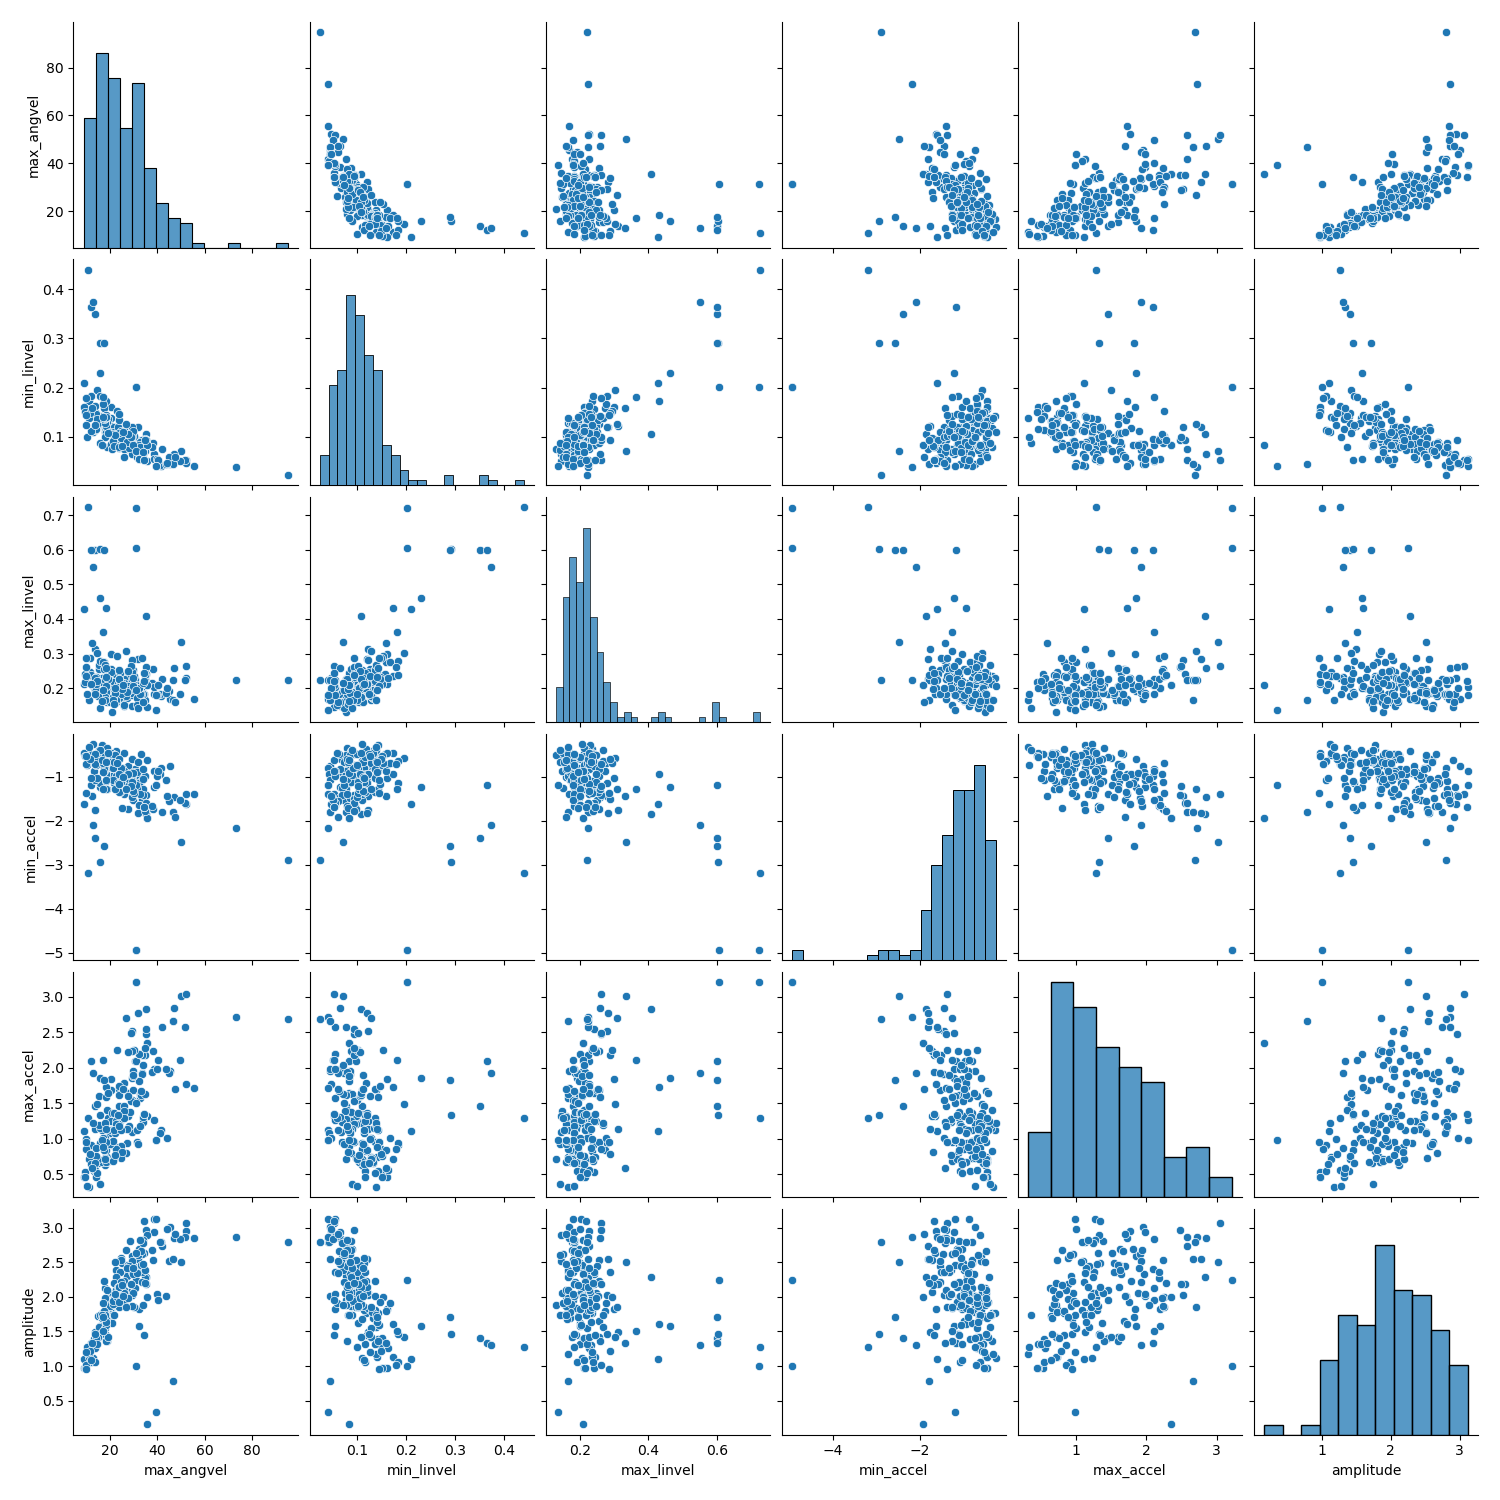

In [112]:
df = pd.DataFrame({"max_angvel": max_angvel, "min_linvel": min_linvel, "max_linvel": max_linvel, "min_accel": min_accel, "max_accel": max_accel, "amplitude": np.abs(amplitudes)})
import seaborn as sns
sns.pairplot(df)

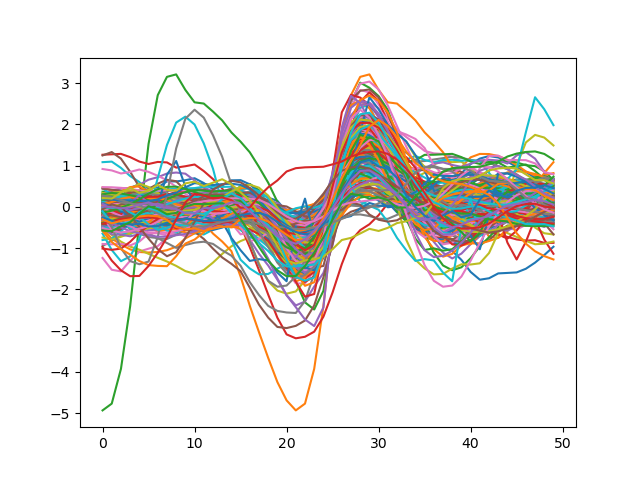

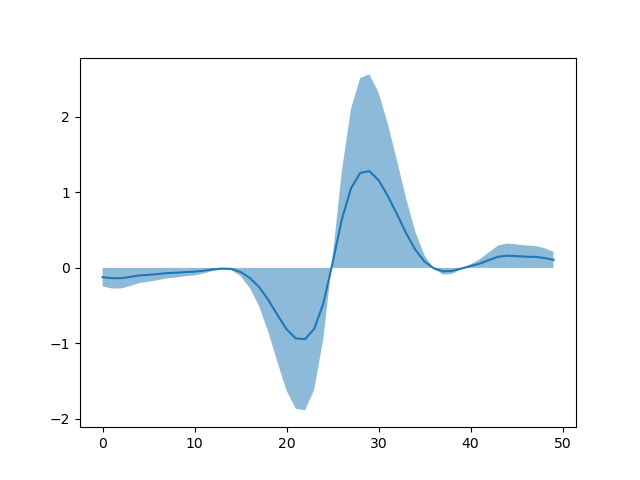

In [113]:
def plot_mean_and_std(data):
    npdata = np.asarray(data)
    fig = plt.figure()
    mean = np.nanmean(npdata, axis=0)
    std = np.nanmean(npdata, axis=0)
    plt.plot(mean)
    plt.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=0.5)
    plt.show()

def plot_all_traces(data):
    fig = plt.figure()
    for d in data:
        plt.plot(d)
    plt.show()

plot_all_traces(accels)
plot_mean_and_std(accels)

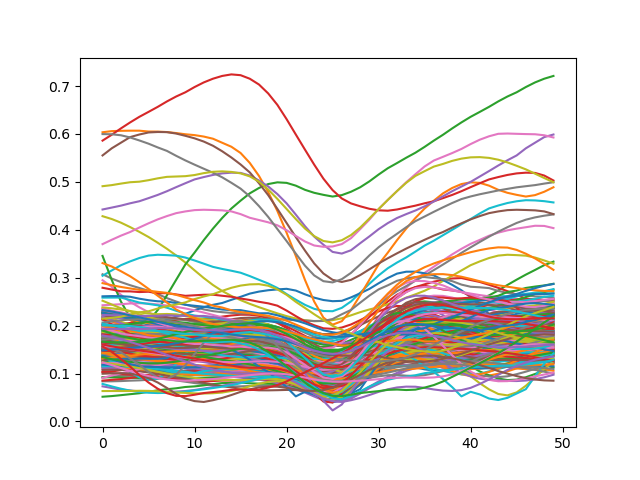

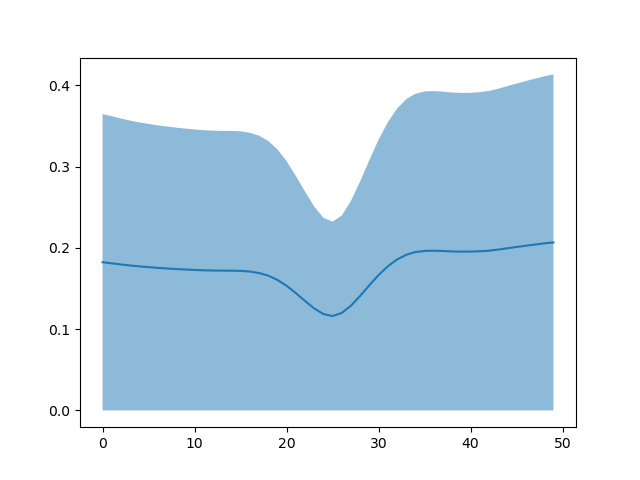

In [114]:
plot_all_traces(linvels)
plot_mean_and_std(linvels)

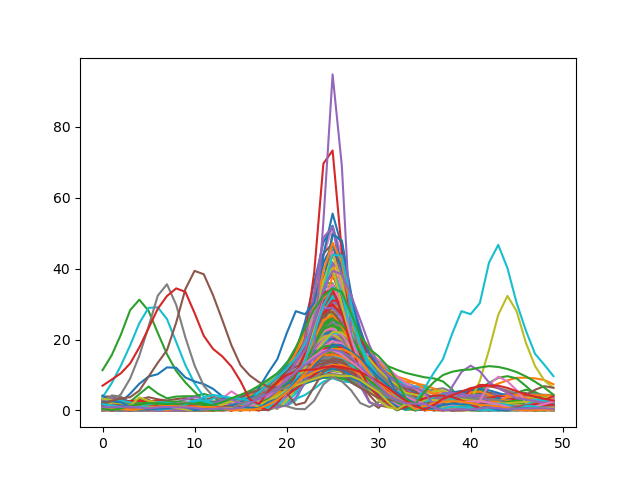

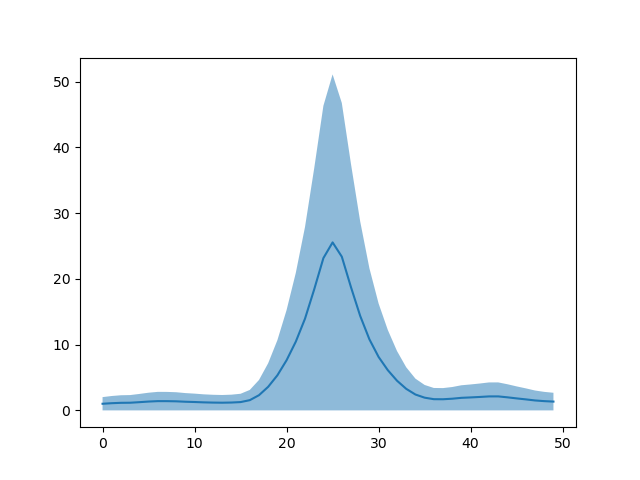

In [115]:
plot_all_traces(np.abs(angvels))
plot_mean_and_std(np.abs(angvels))

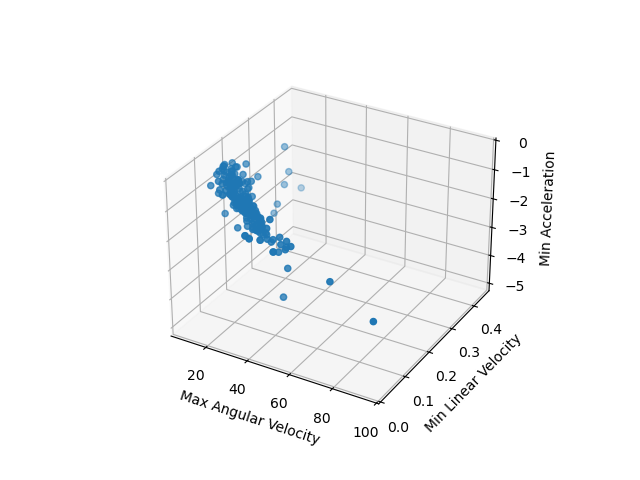

In [116]:
# 3d scatter plot
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(max_angvel, min_linvel, min_accel)
ax.set_xlabel("Max Angular Velocity")
ax.set_ylabel("Min Linear Velocity")
ax.set_zlabel("Min Acceleration")

plt.show()